In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
# Dummy data to test
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-02'),
    first_days=5,
    split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
# Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    first_days=2
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(
    ds_train.compute_weights(), len(ds_train)
)

In [8]:
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=32, sampler=sampler_train
)

In [9]:
gen = Generator(
    nres=1, nf_in=1, nf=16, use_noise=True, activation_out='relu'
).to(device)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [11]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [12]:
X, y = next(iter(dl_train))

In [13]:
y.type()

'torch.FloatTensor'

In [14]:
trainer.fit(50)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


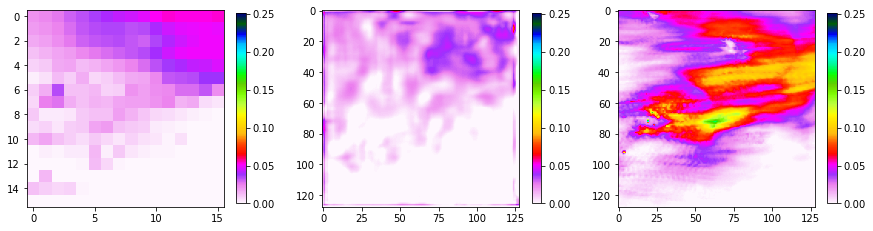

In [16]:
X, y = next(iter(dl_train))
plot_sample(X, y, gen, 0)

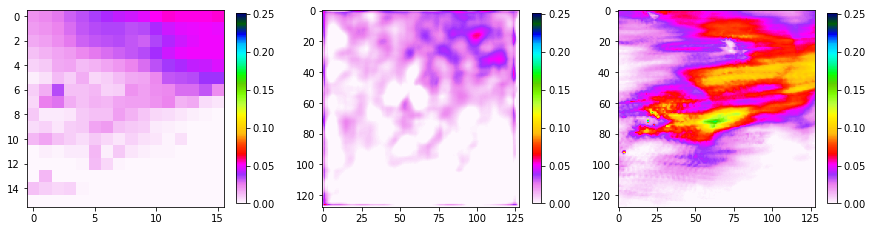

In [17]:
plot_sample(X, y, gen, 0)

## Evaluation

### Get predictions

In [29]:
# Note that we are using xarray datasets for handling our data!
# This makes things SO MUCH easier :)
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        pred = model(torch.FloatTensor(X[None]).to(device)).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(
                lat=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[1])
            ),
            'lon': ds_valid.mrms.lon.isel(
                lon=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[2])
            )
        },
        name='tp'
    )
    return preds

In [30]:
def create_valid_ensemble(model, ds_valid, nens):
    """Wrapper to create ensemble"""
    preds = [create_valid_predictions(model, ds_valid) for _ in range(nens)]
    return xr.concat(preds, 'member')

In [31]:
det_pred = create_valid_predictions(gen, ds_test)

In [32]:
det_pred

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[ 1.7194034 ,  9.808635  ,  6.0944295 , ...,  9.056076  ,
          0.        ,  0.        ],
        [ 8.617303  , 10.617201  ,  6.717217  , ...,  3.8736897 ,
          0.        ,  0.        ],
        [ 6.354095  ,  9.515979  ,  5.2418737 , ...,  0.61558896,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  3.1013522 ,  0.        , ...,  1.7227043 ,
          2.4905093 ,  0.        ],
        [ 3.2892306 ,  8.125695  ,  7.83566   , ...,  7.182081  ,
          7.801329  ,  0.6331126 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  2.373691  ,
          2.7035336 ,  2.7039304 ],
        [10.469372  , 10.132773  ,  5.4784255 , ...,  2.0792198 ,
          3.2755396 ,  1.2094634 ],
        [ 8.794848  , 10.10778   ,  5.7846456 , ...,  0.89075774,
          1.7740005 ,  0.46900913],
...
        [ 0.        ,  4.1602507 ,  1.8250569 , ...,  7.836804  ,
          0.        ,  0.        ],
        [ 3.9601514 ,  8.849172  ,  8.603199  , ...,  2.0493    ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ..., 14.312724  ,
         10.026527  ,  1.6017103 ],
        [13.978684  , 13.709066  ,  7.449197  , ...,  7.9029193 ,
          4.03845   ,  0.        ],
        [11.978209  , 13.480951  ,  8.055143  , ...,  6.4509454 ,
          1.6404626 ,  0.        ],
        ...,
        [ 0.        ,  5.610852  ,  2.316136  , ...,  4.4430223 ,
          1.9234569 ,  0.        ],
        [ 4.0291376 ,  9.75043   ,  8.840325  , ...,  7.9086537 ,
          6.4616427 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [33]:
ens_pred = create_valid_ensemble(gen, ds_test, nens=10)

In [34]:
ens_pred

<xarray.DataArray 'tp' (member: 10, valid_time: 44, lat: 744, lon: 1376)>
array([[[[ 2.7950797 , 10.8266325 ,  5.934971  , ...,  8.467552  ,
           7.6483583 ,  3.6242697 ],
         [10.560906  , 12.698131  ,  8.594239  , ...,  5.8446856 ,
           5.9261184 ,  0.35866335],
         [ 8.38538   , 11.582961  ,  7.1098237 , ...,  3.9609556 ,
           3.6760304 ,  0.        ],
         ...,
         [ 8.246552  , 14.235918  ,  8.381176  , ...,  3.9529855 ,
           1.4423097 ,  0.        ],
         [ 9.989153  , 19.483797  , 17.527775  , ...,  7.19496   ,
           5.6720247 ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  5.9891744 ,  3.6259885 , ...,  7.6875935 ,
           7.0793147 ,  2.7764046 ],
         [ 7.6986876 , 10.181482  ,  6.876095  , ...,  4.246271  ,
           4.5627217 ,  0.        ],
         [ 5.677871  ,  9.341367  ,  5.8749695 , ...,  3.3762257 ,
           3.140283  ,  0.        ],
...
         [ 0.        ,  5.6922464 ,  2.2181356 , ...,  6.8446064 ,
           0.        ,  0.        ],
         [ 0.550502  ,  9.030499  ,  8.227357  , ...,  4.021412  ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[13.648654  , 20.692205  , 13.216686  , ...,  0.52513444,
           1.1506721 ,  3.9151433 ],
         [12.649108  , 14.715613  ,  8.7782135 , ...,  3.2288172 ,
           4.922369  ,  3.9986963 ],
         [ 7.4808645 , 11.183116  ,  5.3463006 , ...,  2.6274126 ,
           3.8333044 ,  3.28303   ],
         ...,
         [ 0.        ,  5.4026656 ,  2.8208163 , ...,  3.4131825 ,
           3.7523022 ,  0.        ],
         [ 2.9713597 ,  9.228357  ,  8.415495  , ...,  8.86478   ,
           9.317571  ,  1.7910721 ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
Dimensions without coordinates: member

### Compute scores

In [67]:
from src.evaluation import *

Need to mask out regions where there is no radar

In [74]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [75]:
eval_mask

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] ...
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [24]:
import xskillscore as xs

In [84]:
mrms = ds_test.mrms.sel(lat=det_pred.lat, lon=det_pred.lon).rename(
    {'time': 'valid_time'}) * ds_test.maxs.tp.values
mrms = mrms.where(eval_mask)

In [85]:
mrms

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[0.00000000e+00, 1.25000002e-02, 6.25000009e-03, ...,
         6.49999976e-01, 3.50000024e-01, 1.68750018e-01],
        [0.00000000e+00, 0.00000000e+00, 5.00000007e-02, ...,
         8.50000024e-01, 4.81249988e-01, 2.00000003e-01],
        [0.00000000e+00, 2.50000004e-02, 5.62499985e-02, ...,
         7.68750012e-01, 5.62500000e-01, 2.62499988e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.50000000e-01, 8.68750036e-01, 9.74999964e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.56250012e-01, 5.87499976e-01, 7.06250012e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.31250006e-01, 5.24999976e-01, 7.50000000e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] 2020-05-16

In [86]:
# Deterministic forecast RMSE
xs.rmse(det_pred, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.0814078)

In [87]:
# Emsemble mean forecast RMSE
xs.rmse(ens_pred.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.02802777)

In [102]:
# Ensemble CRPS
xs.crps_ensemble(mrms, ens_pred).values

array(0.37733087)

### Interpolation baseline

In [88]:
tigge = ds_test.tigge.isel(variable=0) * ds_test.maxs.tp.values
tigge

<xarray.DataArray (valid_time: 44, lat: 93, lon: 172)>
array([[[5.60941339e-01, 1.64720798e+00, 3.38511086e+00, ...,
         9.19832468e-01, 8.54813278e-01, 8.42504144e-01],
        [6.02257252e-01, 2.78425336e-01, 6.16120100e-01, ...,
         8.11713696e-01, 8.54883373e-01, 9.64733124e-01],
        [4.28736401e+00, 2.67114925e+00, 7.84402370e-01, ...,
         7.31913328e-01, 7.93414235e-01, 8.92297804e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.78253812e-04, 1.30272773e-03, 6.09068898e-04],
        [5.64455800e-03, 0.00000000e+00, 0.00000000e+00, ...,
         8.79674703e-02, 3.91880833e-02, 2.56075263e-01],
        [5.51259611e-03, 1.17733609e-04, 1.84860779e-04, ...,
         5.43296635e-01, 3.98564249e-01, 3.01565886e-01]],

       [[1.61871302e+00, 8.74794364e-01, 1.59606063e+00, ...,
         2.12971374e-01, 1.41367301e-01, 9.64245945e-02],
        [8.50851238e-02, 1.49924727e-02, 1.24233827e-01, ...,
         3.11670303e-01, 1.98064640e-01, 9.83297825e-02],
        [1.12202895e+00, 3.78966063e-01, 6.23947382e-02, ...,
         4.26584750e-01, 2.74970740e-01, 1.31330609e-01],
...
        [1.28982589e-04, 1.90190971e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.50150806e-03, 0.00000000e+00, 9.09934344e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.35852944e-03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.14610147e-01, 2.57977962e-01, 1.72763467e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.31259423e-01, 5.08996248e-02, 3.98795009e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.95156568e-01, 1.32262707e-02, 1.62853599e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.77795124e-01, 1.98326781e-01, 7.70029426e-03],
        [0.00000000e+00, 0.00000000e+00, 4.66813520e-03, ...,
         4.77190733e-01, 1.71373904e-01, 9.71573591e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.43066263e-01, 4.00218308e-01, 1.58019304e-01]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-02
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'

In [96]:
interp = tigge.interp_like(mrms, method='linear')

In [97]:
# Deterministic baseline RMSE
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.17905541)

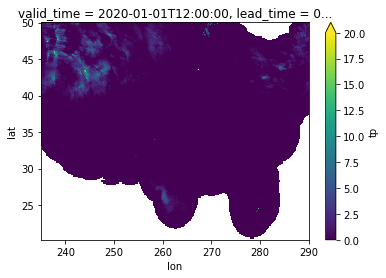

In [98]:
mrms.isel(valid_time=0).plot(vmin=0, vmax=20)

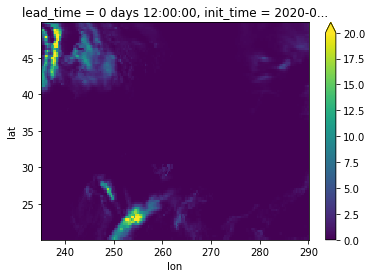

In [99]:
tigge.isel(valid_time=0).plot(vmin=0, vmax=20)

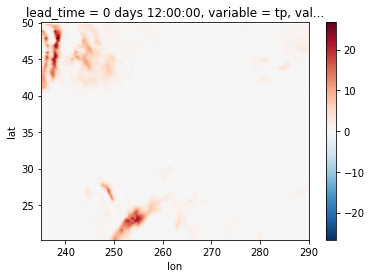

In [100]:
interp.isel(valid_time=0).plot()

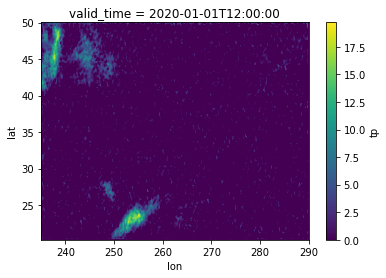

In [101]:
det_pred.isel(valid_time=0).plot()